# Run NetConf on Houston IEEE data

In [1]:
# Import helper functions
# If new server on Descartes Labs, need to install rioxarray 
try: import rioxarray
except: 
    %pip install rioxarray
    
# Import helper functions
import helper_functions as hf
import imports as ip
import netconf.netconf as nc

In [2]:
# Data files
labelFile = './data/2018IEEE_Contest/Phase2/TrainingGT/2018_IEEE_GRSS_DFC_GT_TR.tif'
hsFile = './data/2018IEEE_Contest/Phase2/FullHSIDataset/20170218_UH_CASI_S4_NAD83.pix'
radarFile = './data/2018IEEE_Contest/Phase2/Lidar GeoTiff Rasters/Intensity_C3/UH17_GI3F051.tif'

# A priori beliefs - 2 classes green/built
decisions = {0: False, 1: True}
initBeliefs, confidence = [0.5,0.5], [0,1] # [green, built], probability of being built

# Edge creation
adjacent, geoNeighbours, phase, neighbours = False, 2, True, 3

# Classifications
targets = ['Green', 'Built']

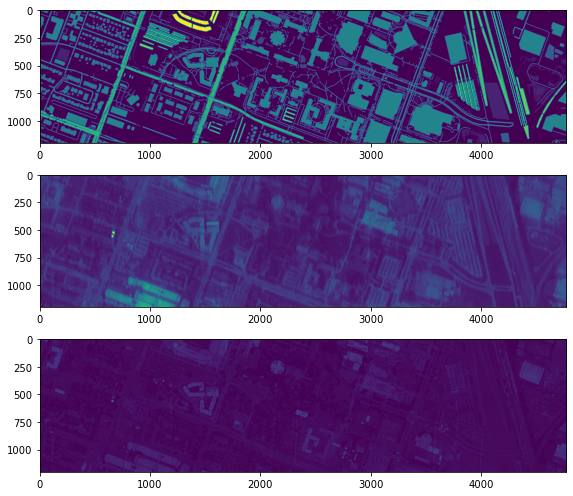

In [4]:
# Import rasters
labels, larr = ip.raster_to_df(labelFile)
hs, hsarr = ip.raster_to_df(hsFile, value='amp', multidims=True, crop=True)
radar, radararr = ip.raster_to_df(radarFile, value='phase', crop=True)

# Plot values
fig, axs = hf.create_subplots(3,1,[10,7])
axs[0].imshow(larr[0])
axs[1].imshow(hsarr[0])
axs[2].imshow(radararr[0])
fig.tight_layout()

In [78]:
# Get geodatabase of every
initial = hf.init_beliefs(hs.loc[:10], columns=['green','built'], crs='EPSG:6577')

geoLabels = hf.df_to_gdf(labels.loc[:10], columns=['class'], crs='EPSG:6577', reIndex=True)
geoLabels['class'] = hf.group_classes(geoLabels['class'], classes = [[1,7],[8,20]], zeroNan = True)

X_train, X_test, y_train, y_test = hf.train_test_split(geoLabels, column = 'class')

nodes = hf.create_nodes(initial, X_train)

# Assign prior beliefs from assessments
priors = hf.prior_beliefs(nodes, decisions, confidence, column = 'class', beliefColumns = ['green', 'built'])

# Create edges
edges = hf.create_edges(nodes, adjacent=adjacent, geo_neighbors=geoNeighbours, values=nodes.columns[:50] if phase else False, neighbours=[neighbours])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [80]:
# Run belief propagation
beliefs, _ = nc.netconf(edges,priors,verbose=True,limit=1e-4)

Nodes: 52448, Edges: 104896
It	Loss	Label change

0	1.09387e+00		14103

1	4.03226e-01		715

2	2.24798e-01		219

3	8.81586e-02		49

4	4.80508e-02		22

5	1.80277e-02		9

6	1.03846e-02		3

7	3.60063e-03		1

8	2.31013e-03		1

9	7.10718e-04		0

10	5.34167e-04		0

11	1.60354e-04		0

12	1.28453e-04		0

13	3.96959e-05		0

Time elapsed: 128.93800234794617 seconds


              precision    recall  f1-score   support

       Green       0.69      0.80      0.74     10830
       Built       0.32      0.21      0.25      4905

    accuracy                           0.61     15735
   macro avg       0.50      0.50      0.50     15735
weighted avg       0.57      0.61      0.59     15735



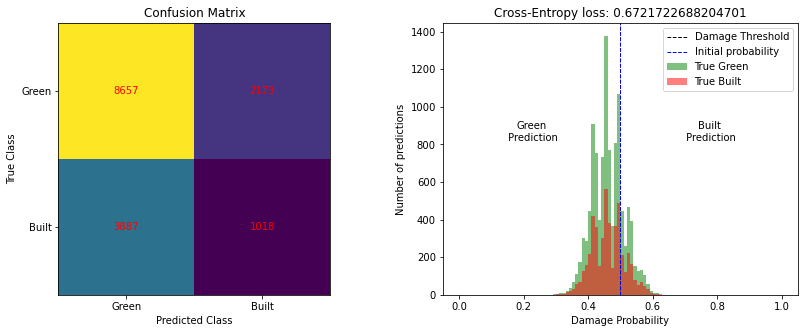

In [81]:
# Evaluation Metrics
# Get y_true vs y_pred for test set
y_true, y_pred = hf.get_labels(initial, X_test, beliefs, decisions, column='class')

# Classification metrics
yp_clf, classes = hf.class_metrics(y_true, y_pred, targets)

fig, axs = hf.create_subplots(1,2, figsize=[14,5])
# Confusion matrix
axs = hf.confusion_matrix(axs, y_true, yp_clf, classes)
  
# Cross entropy / Confidence metrics
axs = hf.cross_entropy_metrics(axs, y_true, y_pred, classes)

hf.show_plot()

In [82]:
# Save figure
hf.save_plot(fig, 'results/Houston_adj{}{}_ps{}{}_hsall_10000'.format(str(adjacent),str(geoNeighbours),str(phase),str(neighbours)))

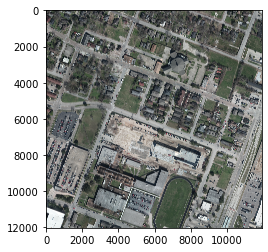

In [24]:
loc = '272056_3290290'
im = Image.open('./data/2018IEEE_Contest/Phase2/Final RGB HR Imagery/UH_NAD83_'+loc+'.tif')
plt.imshow(np.array(im))